# Figure 4: Illustrative Pathways

In [1]:
import pyam 
import matplotlib.pyplot as plt 
from pathlib import Path 
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import string 

plt.style.use(
    "plotting_template.mplstyle"
)

<IPython.core.display.Javascript object>

# Read in the necessary data

In [2]:
data_folder = Path(
    "..", "data"
)

In [3]:
data_file = Path(
    data_folder / "AR6_Scenarios_Snapshot.xlsx"
)

In [4]:
df_ar6 = pyam.IamDataFrame(data_file)

pyam.core - INFO: Reading file ../data/AR6_Scenarios_Snapshot.xlsx


In [5]:
meta_file = Path(
    data_folder / "AR6_Scenarios_Updated_Meta.xlsx"
)

In [6]:
df_ar6.load_meta(meta_file)

We filter and keep the C1 scenarios.

In [7]:
df_c1 = df_ar6.filter(
    Category_rolling_mean="C1",
    year=range(2010, 2105,5)
)

In [8]:
df_c1.interpolate(
    time=range(2015, 2105, 5),
    inplace=True
)

# Check if all scenarios report carbon sequestration from land use emissions

In [9]:
cs_variables_to_check = [ 
    "Carbon Sequestration|CCS|Biomass",
    "Carbon Sequestration|Land Use"
]

In [10]:
for var in cs_variables_to_check:
    df_c1.filter(category_new_rolling_mean="PA*").require_data(var)

We check which scenarios do not report land use sequestration.

In [11]:
df_c1.filter(category_new_rolling_mean="PA*").require_data(variable=var, exclude_on_fail=True)

pyam.validation - INFO: 12 scenarios failed validation and will be set as `exclude=True`.


model                   scenario  \
0             AIM/CGE 2.1       CD-LINKS_NPi2020_400   
1      AIM/Hub-Global 2.0                       1.5C   
2             POLES EMF33          EMF33_WB2C_nofuel   
3              REMIND 1.7     ADVANCE_2020_1.5C-2100   
4              REMIND 2.1       CEMICS_GDPgrowth_1p5   
5              REMIND 2.1  CEMICS_HotellingConst_1p5   
6              REMIND 2.1          CEMICS_Linear_1p5   
7              REMIND 2.1        R2p1_SSP1-PkBudg900   
8              REMIND 2.1        R2p1_SSP5-PkBudg900   
9       REMIND-MAgPIE 1.5                    SSP2-19   
10  REMIND-MAgPIE 1.7-3.0          EMF33_1.5C_nofuel   
11      WITCH-GLOBIOM 3.1                    SSP4-19   

                         variable  
0   Carbon Sequestration|Land Use  
1   Carbon Sequestration|Land Use  
2   Carbon Sequestration|Land Use  
3   Carbon Sequestration|Land Use  
4   Carbon Sequestration|Land Use  
5   Carbon Sequestration|Land Use  
6   Carbon Sequestration|Land Use  
7   Carbon Sequestration|Land Use  
8   Carbon Sequestration|Land Use  
9   Carbon Sequestration|Land Use  
10  Carbon Sequestration|Land Use  
11  Carbon Sequestration|Land Use

11 out of 29 scenarios do not report carbon sequestration from land use separately. To be consistent, we use the net emissions from AFOLU.

In [12]:
df_c1_nzero = df_c1.filter(netzero=True)

In [13]:
co2_afolu = (
    df_c1_nzero
    .filter(variable="Emissions|CO2|AFOLU")
    .timeseries()
)

In [14]:
co2_afolu_nn = co2_afolu.applymap(lambda x: -min(x,0)).reset_index()
co2_afolu_nn.variable = "Carbon Sequestration|AFOLU"

/var/folders/nz/kr7bwztj0_d9xrfz1jd4zcdh0000gp/T/ipykernel_5405/2636368026.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  co2_afolu_nn = co2_afolu.applymap(lambda x: -min(x,0)).reset_index()


In [15]:
co2_afolu_nn_pyam = pyam.IamDataFrame(co2_afolu_nn)

Diagnostic check: Check that all these quantiles are positive

In [16]:
co2_afolu_nn_pyam.validate(
    criteria={"Carbon Sequestration|AFOLU": {"lo": 0}}
)

In [17]:
df_c1_nzero.append( 
    co2_afolu_nn_pyam, 
    inplace=True 
)

# Aggregate non-CO2 emissions

In [18]:
kyoto_gases_excl_co2 = [ 
    "Emissions|N2O",
    "Emissions|CH4",
    "Emissions|SF6",
    "Emissions|HFC|HFC125",
    "Emissions|HFC|HFC134a",
    "Emissions|HFC|HFC143a",
    "Emissions|HFC|HFC227ea",
    "Emissions|HFC|HFC23",
    "Emissions|HFC|HFC32",
    "Emissions|HFC|HFC245fa",
    "Emissions|HFC|HFC43-10",
    "Emissions|PFC|C2F6",
    "Emissions|PFC|C6F14",
    "Emissions|PFC|CF4",
    'Emissions|C2F6',
    'Emissions|CF4'       
]

In [19]:
for variable in kyoto_gases_excl_co2:
    df_c1_nzero.require_data(variable=variable)

Now, we are in a bit of a pickle. So, we use the harmonised F-gas trajectories that are infilled where not available.

In [20]:
kyoto_gases_excl_co2 = [
    "AR6 climate diagnostics|Infilled|Emissions|CH4",
    "AR6 climate diagnostics|Infilled|Emissions|N2O",
    "AR6 climate diagnostics|Infilled|Emissions|F-Gases"
]

In [21]:
kyotoghg_excl_co2 = df_c1_nzero.filter(
    variable = kyoto_gases_excl_co2
)

In [22]:
kyotoghg_excl_co2.unit_mapping

{'AR6 climate diagnostics|Infilled|Emissions|CH4': 'Mt CH4/yr',
 'AR6 climate diagnostics|Infilled|Emissions|F-Gases': 'Mt CO2/yr',
 'AR6 climate diagnostics|Infilled|Emissions|N2O': 'kt N2O/yr'}

In [23]:
kyotoghg_excl_co2.convert_unit(
    current="Mt CH4/yr",
    to="Mt CO2-equiv/yr",
    context="AR6GWP100",
    inplace=True
)

In [24]:
kyotoghg_excl_co2.convert_unit(
    current="Mt N2O/yr",
    to="Mt CO2-equiv/yr",
    context="AR6GWP100",
    inplace=True
)

In [25]:
kyotoghg_excl_co2.convert_unit(
    current="kt N2O/yr",
    to="Mt CO2-equiv/yr",
    context="AR6GWP100",
    inplace=True
)

In [26]:
kyotoghg_excl_co2.rename(
    unit={"Mt CO2-equiv/yr": "Mt CO2/yr"},
    inplace=True
)

In [27]:
kyotoghg_excl_co2.interpolate(
    time=range(2010, 2105,5),
    inplace=True
)

In [28]:
kyotoghg_excl_co2.aggregate(
    variable="Emissions|KyotoGHG|excl. CO2",
    components=kyoto_gases_excl_co2,
    append=True
)

In [29]:
df_c1_nzero.append(
    kyotoghg_excl_co2.filter(
        variable="Emissions|KyotoGHG|excl. CO2",
        year=range(2010, 2105,5)
    ),
    inplace=True
)

# Check if the DAC reporting issues from ENGAGE have been resolved

<Axes: title={'center': 'region: World - variable: Carbon Sequestration|Direct Air Capture'}, xlabel='Year', ylabel='Mt CO2/yr'>

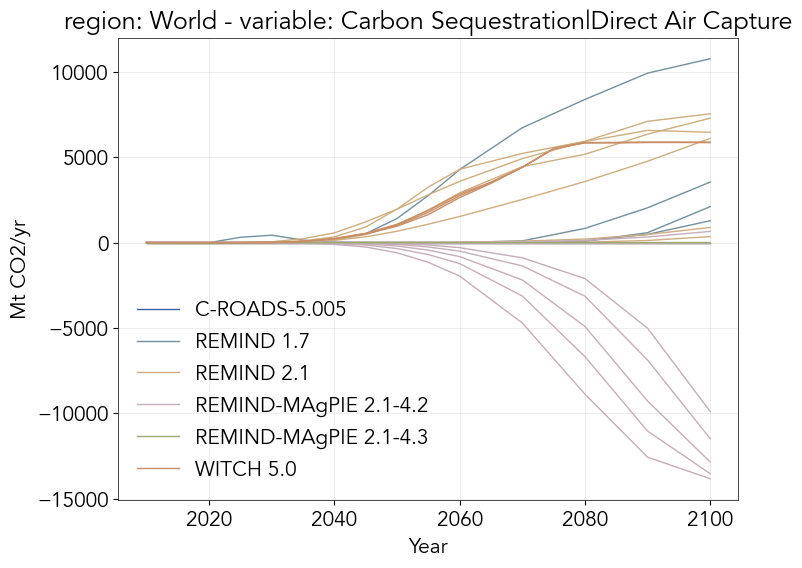

In [30]:
df_c1_nzero.filter(
    variable="Carbon Sequestration|Direct Air Capture"
).plot(color="model")

In [31]:
dac_remind = df_c1_nzero.filter(
    model="REMIND-MAgPIE 2.1-4.2", 
    variable="Carbon Sequestration|Direct Air Capture", 
    scenario="EN*",
    region="World"
)

<Axes: title={'center': 'model: REMIND-MAgPIE 2.1-4.2 - region: World - variable: Carbon Sequestration|Direct Air Capture'}, xlabel='Year', ylabel='Mt CO2/yr'>

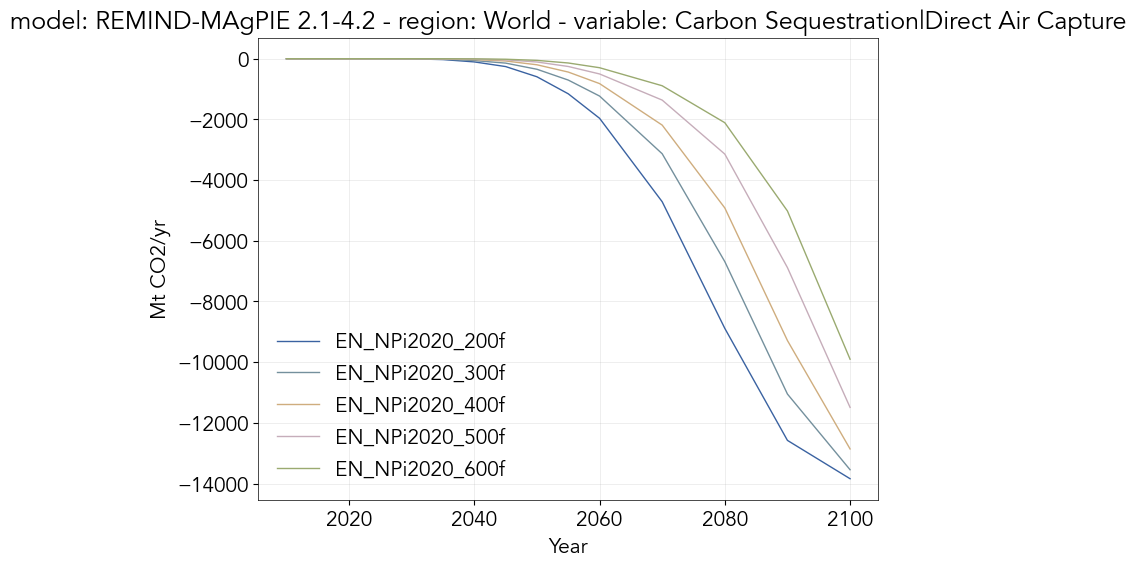

In [32]:
dac_remind.plot()

In [33]:
dac_remind.convert_unit(
    current="Mt CO2/yr", 
    to="Mt CO2/yr", 
    factor=-1, 
    inplace=True
)

In [34]:
df_c1_nzero.filter(
    model="REMIND-MAgPIE 2.1-4.2", 
    scenario="EN*",
    variable="Carbon Sequestration|Direct Air Capture", 
    keep=False, 
    inplace=True
)

In [35]:
df_c1_nzero.append(
    dac_remind, 
    inplace=True
)

In [36]:
df_c1_nzero.aggregate(
    variable="Carbon Dioxide Removal",
    components=[ 
        "Carbon Sequestration|CCS|Biomass",
        "Carbon Sequestration|AFOLU",
        "Carbon Sequestration|Direct Air Capture",
        "Carbon Sequestration|Enhanced Weathering"
    ],
    append=True
)

In [37]:
def _cross_threshold(x):
    y = pyam.timeseries.cross_threshold(x, threshold=0.1)
    # set threshold slightly above 0 to catch convergence to 0
    return y[0] if len(y) else 2101 #I adapt this to 2101 to catch the >2100 explicitly

def calculate_netzero(_df):
    return _df.apply(_cross_threshold, raw=False, axis=1)

In [38]:
df_c1_imp = df_c1_nzero.filter(
   IMP_marker = "SP" 
)

# Assign year of net zero emissions

In [39]:
kyoto_gases = df_c1_nzero.filter(
    variable="AR6 climate diagnostics|Infilled|Emissions|Kyoto Gases (AR6-GWP100)"
).timeseries()

In [40]:
df_c1_nzero.set_meta(
    calculate_netzero(kyoto_gases),
    name="netzero|kyotoghg"
)

# Identify illustrative pathways

In [41]:
df_c1_nzero.set_meta_from_data(
    name="non_co2_2030",
    variable="Emissions|KyotoGHG|excl. CO2",
    year=2030
)

In [42]:
df_c1_nzero.set_meta_from_data(
    name="cdr_2100",
    variable="Carbon Dioxide Removal",
    year=2100
)

In [43]:
mod_scens_color = [ 
    ("MESSAGEix-GLOBIOM 1.0", "LowEnergyDemand_1.3_IPCC", "#e69f25",),
    ("REMIND-MAgPIE 2.1-4.2", "SusDev_SDP-PkBudg1000", "#069f72"), 
    ("MESSAGE-GLOBIOM 1.0", "SSP2-19", "#0773b2")
]

In [44]:
plt.rcParams['lines.linewidth'] = 2

In [45]:
def plotting_helper(variable, ax, **kwargs):
    for mod, scen, color in mod_scens_color:
        plot_data = df_c1_nzero.filter(
            model = mod, 
            scenario = scen, 
            variable = variable
        )
        plot_data.convert_unit(current = "Mt CO2/yr", to="Gt CO2/yr", inplace = True)
        plot_data.convert_unit(current = "Mt CO2-equiv/yr", to = "Gt CO2-equiv/yr", inplace=True)
        plot_data.plot(
            ax = ax,
            color = color, 
            **kwargs
        )
        if variable in [
            "AR6 climate diagnostics|Infilled|Emissions|Kyoto Gases (AR6-GWP100)", 
            "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|Rolling Mean|50.0th Percentile"
        ]:
            _vertline = df_c1_nzero.filter( 
                model = mod, 
                scenario = scen
            ).meta["netzero|kyotoghg"].values[0]
            print(_vertline)
            ax.axvline(_vertline, color = color, alpha=0.4)
    ax.set_title("")

2098
2089
2067
2098
2089
2067


/var/folders/nz/kr7bwztj0_d9xrfz1jd4zcdh0000gp/T/ipykernel_5405/2561242827.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,0].set_yticklabels([0, 0, -5, -10 ,-15, -20])


Text(2070, 30, 'Net zero\nGHG year')

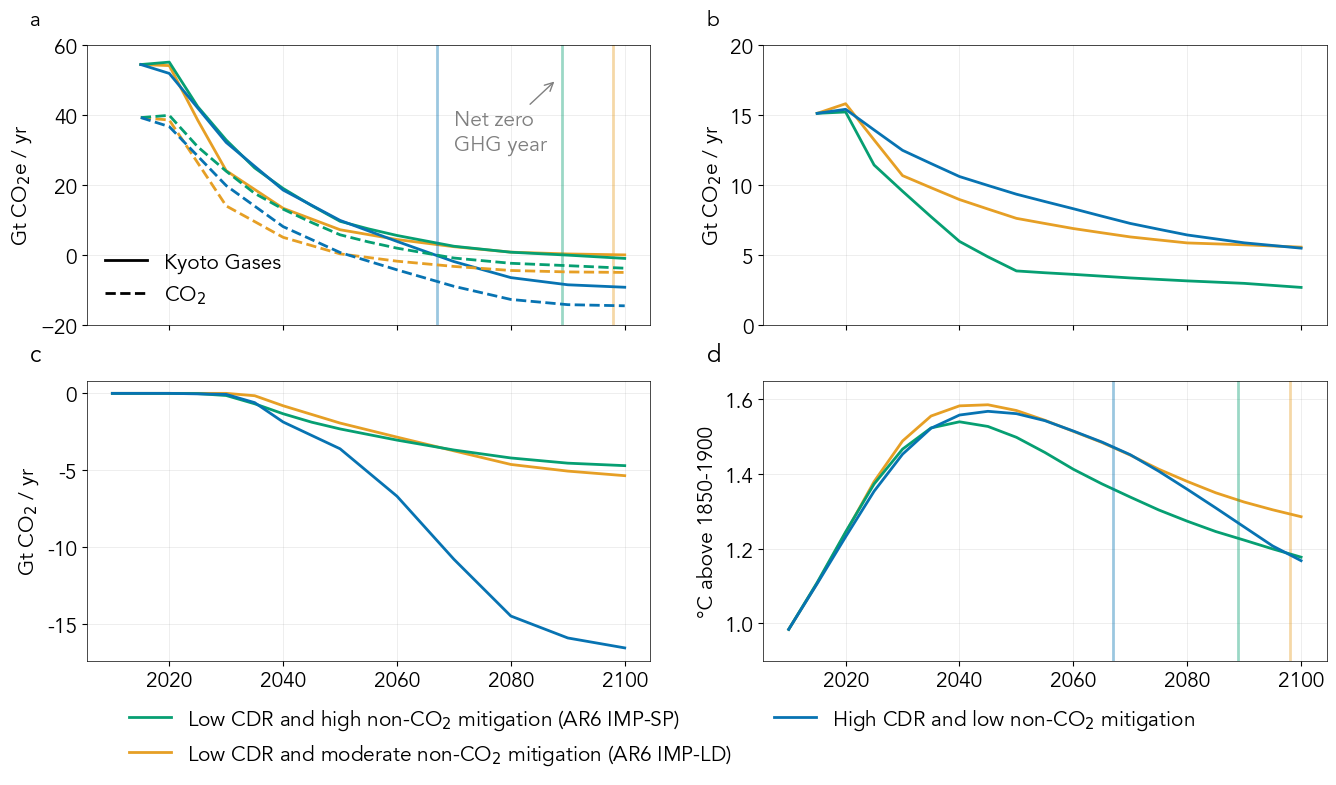

In [46]:
fig, ax = plt.subplots(2, 2, sharex = True, figsize = (16, 8))

leg_str = list()
plotting_helper("Carbon Dioxide Removal", ax=ax[1,0]) # Panel C
plotting_helper("AR6 climate diagnostics|Infilled|Emissions|Kyoto Gases (AR6-GWP100)", ax=ax[0,0]) # Add CO2 and shift to Panel A + vertical for time of n zero GHG
plotting_helper("Emissions|KyotoGHG|excl. CO2", ax=ax[0,1]) # Non CO2 is Panel B
plotting_helper("AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|Rolling Mean|50.0th Percentile", ax=ax[1,1]) # Panel D
plotting_helper("AR6 climate diagnostics|Infilled|Emissions|CO2", ax=ax[0,0], linestyle="dashed")

# Update axes
ax[0,0].set_ylim(-20, 60)
ax[0,1].set_ylim(0,20)
ax[1,1].set_ylim(0.9, 1.65)

# Add annotations
for n, a in enumerate(ax[0]):
    a.set_xlabel("")
    a.text(
        -0.1, 1.07, 
        string.ascii_lowercase[n], 
        transform=a.transAxes,
        size=15, 
        weight='bold'
    )

for n, a in enumerate(ax[1]):
    a.set_xlabel("")
    a.text(
        -0.1, 1.07, 
        string.ascii_lowercase[n+2], 
        transform=a.transAxes,
        size=17, 
        weight='bold'
    )

# Construct a custom legend
custom_legend = [ 
    Line2D([0], [0], color = "black", lw=2, label = "Kyoto Gases"),
    Line2D([0], [0], color = "black", label = "CO$_2$", linestyle = "dashed")
]

# Plot details
ax[0,0].legend(
    handles=custom_legend, 
)

second_custom_legend = [
    Line2D([0], [0], color = "#069f72", lw=2, label = "Low CDR and high non-CO$_2$ mitigation (AR6 IMP-SP)"), 
    Line2D([0], [0], color = "#e69f25", lw=2, label = "Low CDR and moderate non-CO$_2$ mitigation (AR6 IMP-LD)"), 
    Line2D([0], [0], color = "#0773b2", lw=2, label = "High CDR and low non-CO$_2$ mitigation")
]

ax[1,0].legend(
    handles = second_custom_legend, 
    ncol = 2, 
    bbox_to_anchor = (2, -0.1)
)

# Y labels 
ax[0,0].set_ylabel("Gt CO$_2$e / yr")
ax[1,0].set_ylabel("Gt CO$_2$ / yr")
ax[0,1].set_ylabel("Gt CO$_2$e / yr")
ax[1,1].set_ylabel("°C above 1850-1900")

ax[1,0].invert_yaxis()
ax[1,0].set_yticklabels([0, 0, -5, -10 ,-15, -20])

# New: add an annotation for the year of net zero GHG emissions
ax[0,0].annotate("Net zero\nGHG year",
    xy=(2088, 50), xycoords='data',
    xytext=(2070, 30), textcoords='data',
    color = "grey",
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3",
                    color = "grey"),
)

In [47]:
fig.savefig(
    Path("figures/Figure 4.png")
)